# Auto SARIMA

## Imports

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

## Data

In [18]:
# Carregar o conjunto de dados
df = pd.read_csv("../data/commerce_dataset_clean.csv", sep=";")

In [19]:
# Converter a coluna 'dtme' para datetime e definir como índice do DataFrame
df["dtme"] = pd.to_datetime(df["dtme"])
df.set_index("dtme", inplace=True)

In [20]:
# Agregar os totais de vendas por dia
sales_daily = df.groupby("dtme")["total"].sum()

# Visualizar as primeiras entradas da série agregada
sales_daily.head()

dtme
2019-01-01    4745.1810
2019-01-02    1945.5030
2019-01-03    2078.1285
2019-01-04    1623.6885
2019-01-05    3536.6835
Name: total, dtype: float64

## Model

In [21]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(
    sales_daily,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=12,  # 12 is the frequncy of the cycle
    start_P=0,
    seasonal=True,  # set to seasonal
    d=None,
    D=1,  # order of the seasonal differencing
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

# Print the summary of the model
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   89
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -689.619
Date:                            Mon, 26 Feb 2024   AIC                           1389.239
Time:                                    21:05:00   BIC                           1400.958
Sample:                                01-01-2019   HQIC                          1393.926
                                     - 03-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     45.4400     78.481      0.579      0.563    -108.381     199.261
ar.L1          0.8817      0.205   

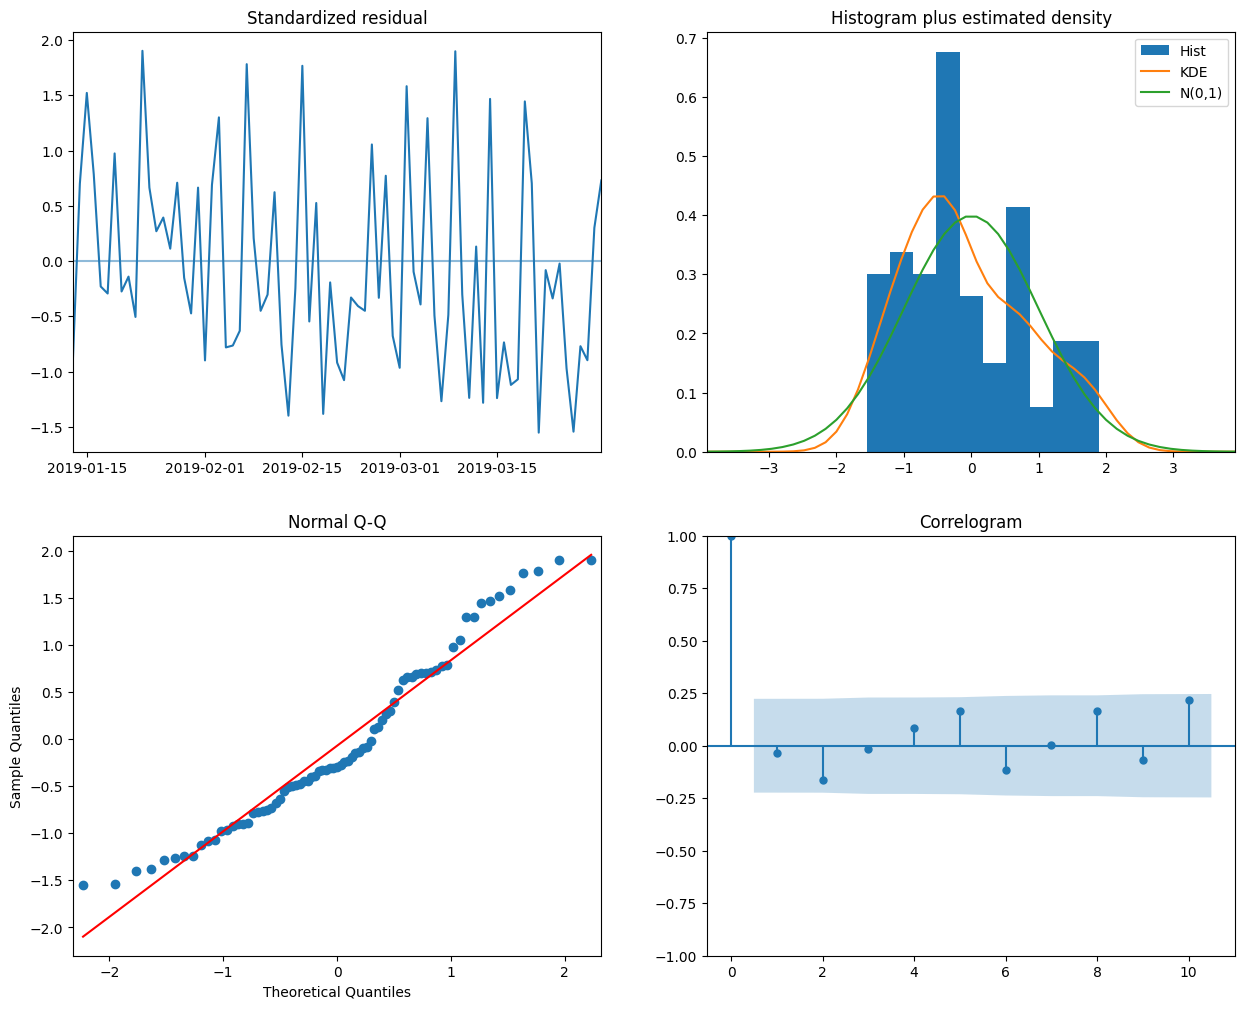

In [22]:
SARIMA_model.plot_diagnostics(figsize=(15, 12))
plt.show()

## Plot

In [23]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(
        sales_daily.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq="D"
    )

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(sales_daily, color="#1f76b4")
    plt.plot(fitted_series, color="darkgreen")
    plt.fill_between(
        lower_series.index, lower_series, upper_series, color="k", alpha=0.15
    )

    plt.title("ARIMA/SARIMA - Forecast of Daily Sales")
    plt.show()

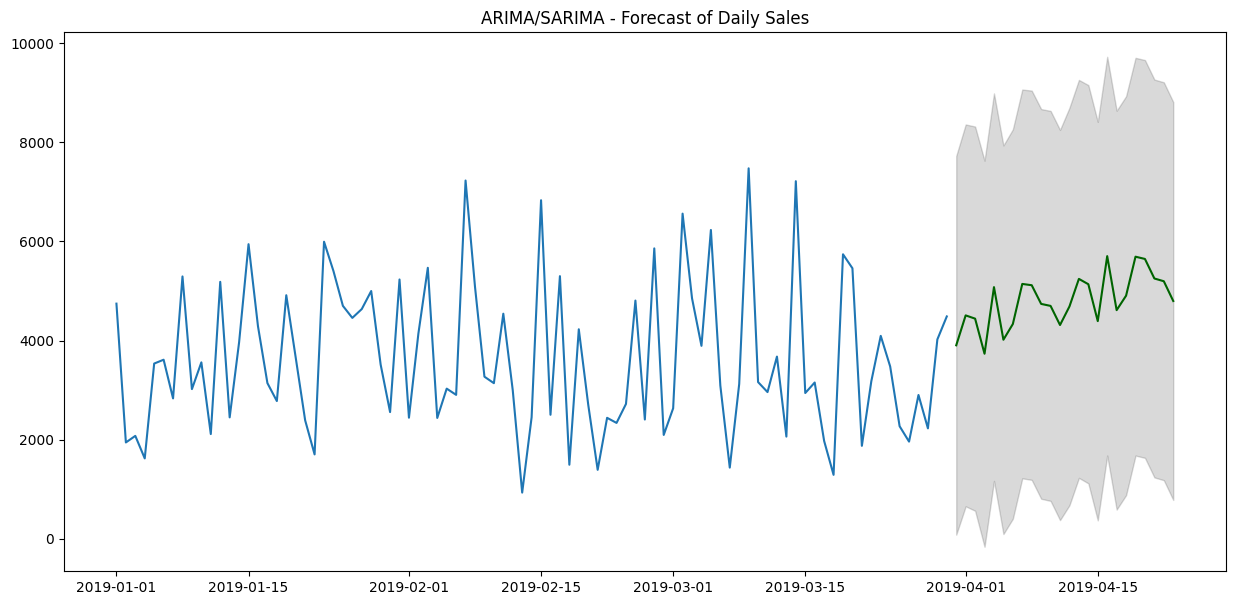

In [24]:
forecast(SARIMA_model)